In [3]:
%matplotlib inline

import jittor
import jittor as jt
import jittor.nn as nn
from jittor import transform

import numpy as np
import matplotlib.pyplot as plt

# Uncomment to use gpu
# jt.flags.use_cuda = 1
    
print('Using Jittor version:', jittor.__version__)

[i 0304 19:15:22.200767 36 compiler.py:956] Jittor(1.3.8.5) src: d:\newapp\anaconda\envs\pytorch\lib\site-packages\jittor
[i 0304 19:15:22.248985 36 compiler.py:957] cl at C:\Users\86151\.cache\jittor\msvc\VC\_\_\_\_\_\bin\cl.exe(19.29.30133)
[i 0304 19:15:22.248985 36 compiler.py:958] cache_path: C:\Users\86151\.cache\jittor\jt1.3.8\cl\py3.10.8\Windows-10-10.xf4\11thGenIntelRCxaa\default
[i 0304 19:15:22.252972 36 install_cuda.py:93] cuda_driver_version: [12, 0, 0]
[i 0304 19:15:22.293832 36 __init__.py:411] Found C:\Users\86151\.cache\jittor\jtcuda\cuda11.2_cudnn8_win\bin\nvcc.exe(11.2.67) at C:\Users\86151\.cache\jittor\jtcuda\cuda11.2_cudnn8_win\bin\nvcc.exe.
[i 0304 19:15:22.497285 36 compiler.py:1011] cuda key:cu11.2.67
Compiling jit_utils_core(5/5) used: 2.611s eta: 0.000s
Compiling jit_utils_core(5/5) used: 2.378s eta: 0.000s
Compiling jittor_core(151/151) used: 56.894s eta: 0.000ss


296kB [00:06, 49.9kB/s]


Compiling libcutt(9/9) used: 81.935s eta: 0.000s
Compiling gen_ops_cutt_test_cutt_transpose(4/4) used: 2.187s eta: 0.000s


6.70MB [00:00, 11.2MB/s]                                                                                               


Compiling gen_ops_mkl_conv_backward_w_mkl_conv_backward_x_mk___hashc4699b(7/7) used: 3.207s eta: 0.000s
Compiling libcuda_extern(3/3) used: 3.902s eta: 0.000s
Compiling gen_ops_cub_argsort_cub_arg_reduce_cub_cumsum_cub____hash7542fc(6/6) used: 2.356s eta: 0.000s
Compiling gen_ops_cublas_acc_matmul_cublas_batched_matmul_cu___hashe0fa5d(8/8) used: 2.541s eta: 0.000s
Compiling gen_ops_cudnn_conv3d_backward_w_cudnn_conv3d_backw___hash78c3ee(16/16) used: 5.364s eta: 0.000s
Compiling gen_ops_curand_random(4/4) used: 2.227s eta: 0.000s
Compiling gen_ops_cufft_fft(3/3) used: 2.137s eta: 0.000s
Using Jittor version: 1.3.8.5


In [4]:
batch_size = 32

train_loader = jt.dataset.MNIST(
    './data/', 
    train=True, 
    batch_size=batch_size, 
    shuffle=True, 
    transform=transform.Gray())

validation_loader = jt.dataset.MNIST(
    './data/', 
    train=False, 
    batch_size=1, 
    shuffle=False, 
    transform=transform.Gray())

9.46MB [00:13, 713kB/s]                                                                                                


32.0kB [00:00, 44.9kB/s]                                                                                               


1.58MB [00:03, 490kB/s]                                                                                                


8.00kB [00:01, 4.87kB/s]                                                                                               


In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.dtype)
    print('y_train:', y_train.size(), 'type:', y_train.dtype)
    break

X_train: [32,1,28,28,] type: float32
y_train: [32,] type: int32


[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]


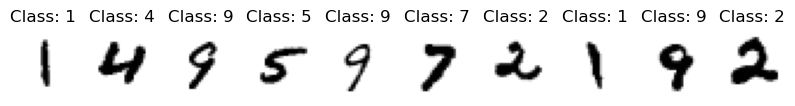

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    print(X_train.shape)
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
    def execute(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = nn.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = nn.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return nn.log_softmax(self.fc3(x), dim=1)

model = Net()
optimizer = jt.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
    fc1: Linear(784, 100, float32[100,], None)
    fc1_drop: Dropout(0.2, is_train=False)
    fc2: Linear(100, 80, float32[80,], None)
    fc2_drop: Dropout(0.2, is_train=False)
    fc3: Linear(80, 10, float32[10,], None)
)


In [8]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate and update weights
        optimizer.step(loss)  #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [9]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.argmax(dim=1)[0] # get the index of the max log-probability
        correct += (pred == target).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.float32() / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [10]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/1875 (0%)]	Loss: 2.311994
Train Epoch: 1 [6400/1875 (11%)]	Loss: 2.089753
Train Epoch: 1 [12800/1875 (21%)]	Loss: 1.277520
Train Epoch: 1 [19200/1875 (32%)]	Loss: 0.740609
Train Epoch: 1 [25600/1875 (43%)]	Loss: 0.554932
Train Epoch: 1 [32000/1875 (53%)]	Loss: 0.389584
Train Epoch: 1 [38400/1875 (64%)]	Loss: 0.440219
Train Epoch: 1 [44800/1875 (75%)]	Loss: 0.409090
Train Epoch: 1 [51200/1875 (85%)]	Loss: 0.456613
Train Epoch: 1 [57600/1875 (96%)]	Loss: 0.663428

Validation set: Average loss: 0.3357, Accuracy: 9031/10000 (90%)

Train Epoch: 2 [0/1875 (0%)]	Loss: 0.544727
Train Epoch: 2 [6400/1875 (11%)]	Loss: 0.660335
Train Epoch: 2 [12800/1875 (21%)]	Loss: 0.372212
Train Epoch: 2 [19200/1875 (32%)]	Loss: 0.406104
Train Epoch: 2 [25600/1875 (43%)]	Loss: 0.482774
Train Epoch: 2 [32000/1875 (53%)]	Loss: 0.294601
Train Epoch: 2 [38400/1875 (64%)]	Loss: 0.276317
Train Epoch: 2 [44800/1875 (75%)]	Loss: 0.229009
Train Epoch: 2 [51200/1875 (85%)]	Loss: 0.252866
Train Epoch: 2

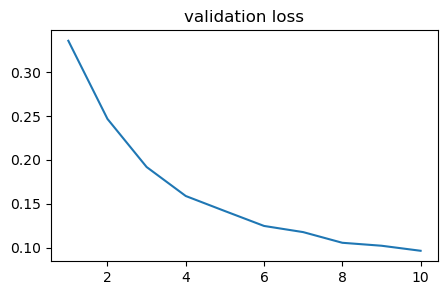

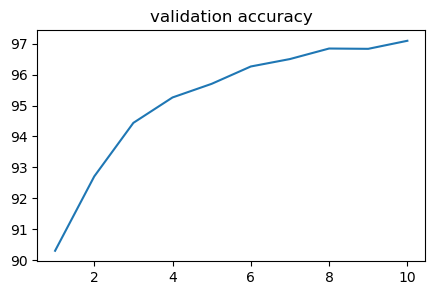

In [11]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1, epochs + 1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1, epochs + 1), accv)
plt.title('validation accuracy');

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

D:\newapp\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PyTorch version: 1.13.0  Device: cuda


In [4]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:06<00:00, 1479575.84it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 388467.09it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 3089680.50it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4238159.90it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


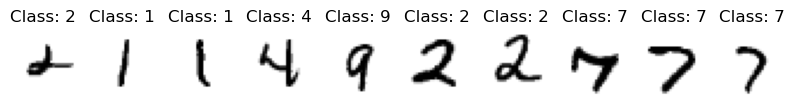

In [7]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


In [9]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [10]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [11]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304779
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.963818
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.114390
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.869821
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.634770
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.515376
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.658085
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.649352
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.286337
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.526783

Validation set: Average loss: 0.3465, Accuracy: 9017/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.480502
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.480287
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.262179
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.547949
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.509013
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.392767
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.349621
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.345007
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.20

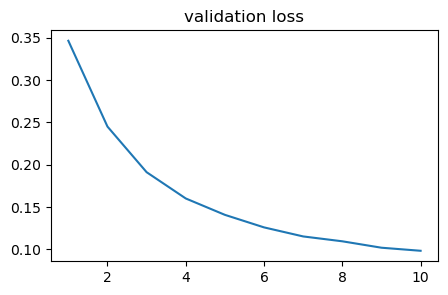

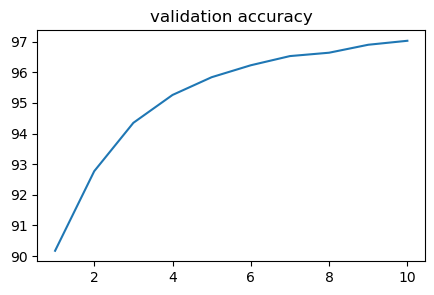

In [12]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 定义ResMLP模型
class ResMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers):
        super(ResMLP, self).__init__()
        self.in_layer = nn.Linear(in_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_layers)])
        self.out_layer = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.in_layer(x)
        for layer in self.hidden_layers:
            x = x + self.relu(layer(x))
        x = self.out_layer(x)
        return x

# 加载MNIST数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# 定义超参数
batch_size = 64
learning_rate = 0.001
num_epochs = 2

# 定义数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型、损失函数和优化器
model = ResMLP(28*28, 256, 10, 5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# 测试模型
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/2], Step [100/938], Loss: 0.2540
Epoch [1/2], Step [200/938], Loss: 0.3838
Epoch [1/2], Step [300/938], Loss: 0.3962
Epoch [1/2], Step [400/938], Loss: 0.1137
Epoch [1/2], Step [500/938], Loss: 0.1683
Epoch [1/2], Step [600/938], Loss: 0.2459
Epoch [1/2], Step [700/938], Loss: 0.1431
Epoch [1/2], Step [800/938], Loss: 0.3844
Epoch [1/2], Step [900/938], Loss: 0.2613
Epoch [2/2], Step [100/938], Loss: 0.1314
Epoch [2/2], Step [200/938], Loss: 0.2636
Epoch [2/2], Step [300/938], Loss: 0.1753
Epoch [2/2], Step [400/938], Loss: 0.1445
Epoch [2/2], Step [500/938], Loss: 0.2876
Epoch [2/2], Step [600/938], Loss: 0.2340
Epoch [2/2], Step [700/938], Loss: 0.0268
Epoch [2/2], Step [800/938], Loss: 0.0586
Epoch [2/2], Step [900/938], Loss: 0.1381
Accuracy of the model on the 10000 test images: 97.06 %


In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

D:\newapp\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PyTorch version: 1.13.0  Device: cuda


In [4]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [6]:
# 定义ResMLP模型
class ResMLP(nn.Module):
    def __init__(self):
        super(ResMLP, self).__init__()
        self.in_layer = nn.Linear(28*28, 256)
        self.hidden_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        ) for i in range(5)])
        self.out_layer = nn.Linear(256, 10)


    def forward(self, x):
        x = x.view(-1, 28*28)
        x =  F.relu(self.in_layer(x))
        for layer in self.hidden_layers:
            x = x + layer(x)
        x = self.out_layer(x)
        return x

In [7]:
model = ResMLP().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.75)
criterion = nn.CrossEntropyLoss()

print(model)

ResMLP(
  (in_layer): Linear(in_features=784, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (out_layer): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed

        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [9]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [10]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318390
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.346768
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.612874
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.269805
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.377647
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.143688
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.062750
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.327048
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.043252
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.370943

Validation set: Average loss: 0.1558, Accuracy: 9502/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.202869
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.021794
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.360671
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.138785
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.092874
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.059786
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.239219
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.082973
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.09

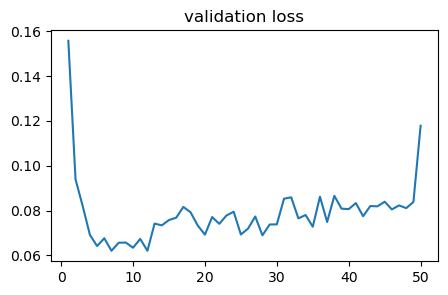

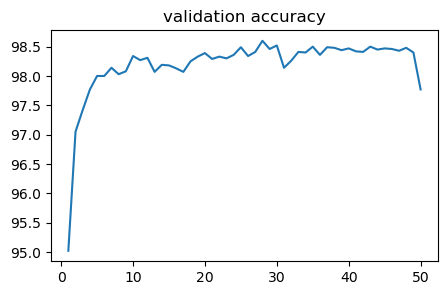

In [11]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

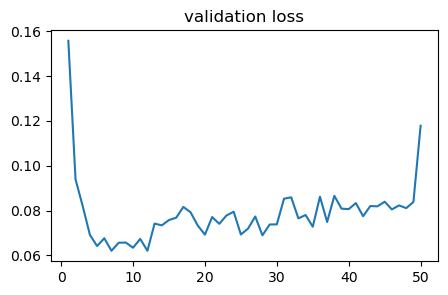

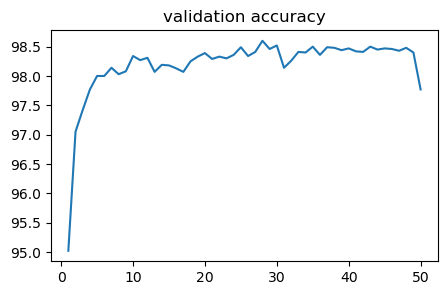

In [12]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

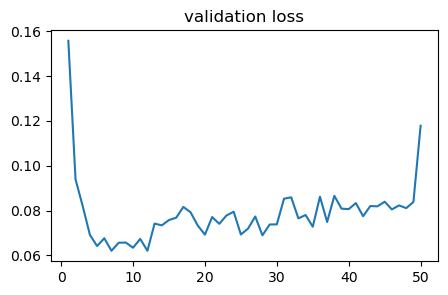

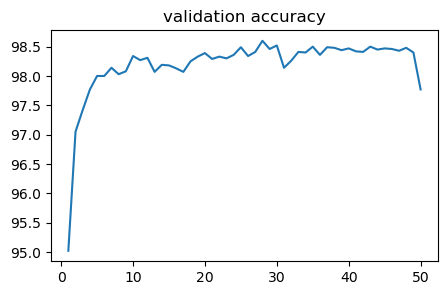

In [13]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

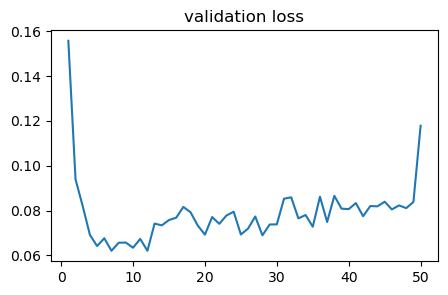

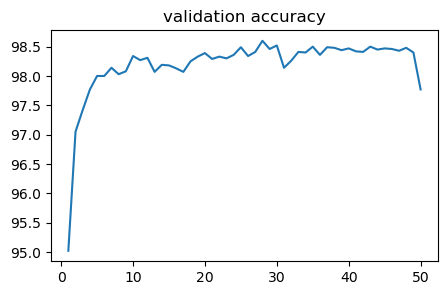

In [14]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

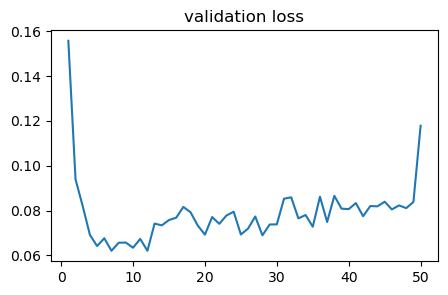

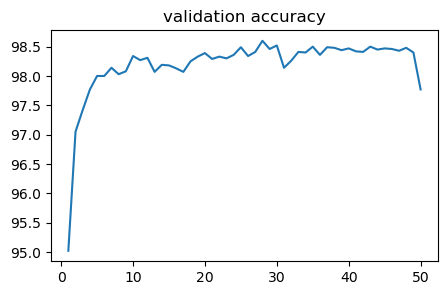

In [15]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

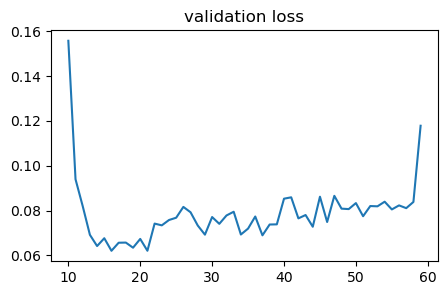

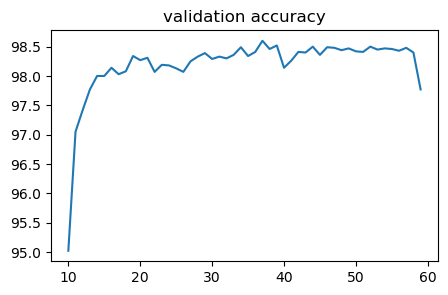

In [17]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(10,epochs+10), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(10,epochs+10), accv)
plt.title('validation accuracy');

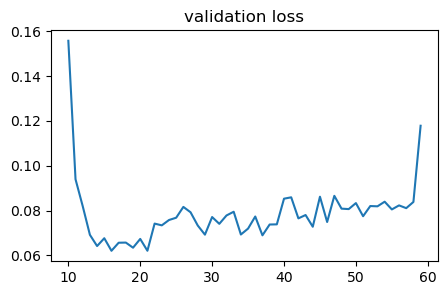

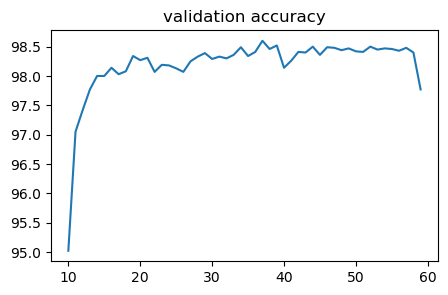

In [18]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(10,epochs+10), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(10,epochs+10), accv)
plt.title('validation accuracy');

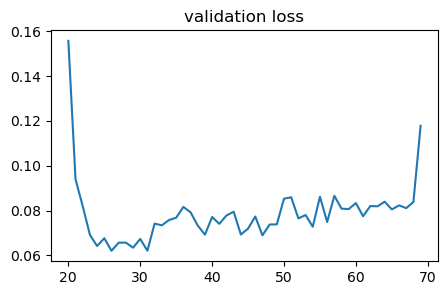

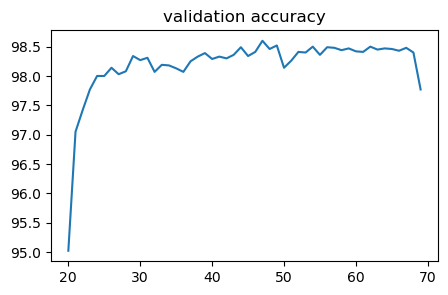

In [19]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(20,epochs+20), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(20,epochs+20), accv)
plt.title('validation accuracy');

In [20]:
# 定义ResMLP模型
class ResMLP(nn.Module):
    def __init__(self):
        super(ResMLP, self).__init__()
        self.in_layer = nn.Linear(28*28, 384)
        self.hidden_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(384, 384),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        ) for i in range(4)])
        self.out_layer = nn.Linear(384, 10)


    def forward(self, x):
        x = x.view(-1, 28*28)
        x =  F.relu(self.in_layer(x))
        for layer in self.hidden_layers:
            x = x + layer(x)
        x = self.out_layer(x)
        return x
model = ResMLP().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.75)
criterion = nn.CrossEntropyLoss()

print(model)

ResMLP(
  (in_layer): Linear(in_features=784, out_features=384, bias=True)
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (out_layer): Linear(in_features=384, out_features=10, bias=True)
)


In [21]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327331
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.510721
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.306249
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.130884
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.172879
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.071392
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.217734
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.104397
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.120164
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.163972

Validation set: Average loss: 0.1329, Accuracy: 9576/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.290971
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.038242
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.024373
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.370422
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.118104
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.040707
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.177384
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.145295
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.10

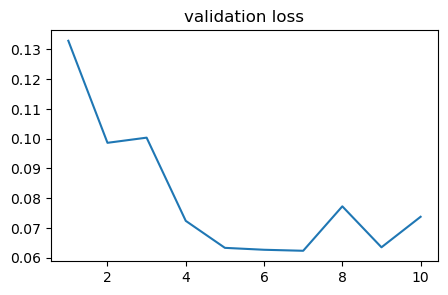

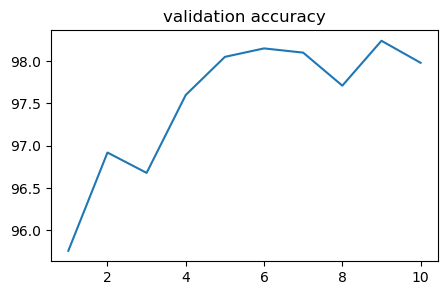

In [22]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


In [24]:
%%time
epochs = 25

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298062
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.980343
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.491672
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.653745
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.571212
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.797831
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.658996
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.586348
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.550507
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.335511

Validation set: Average loss: 0.3368, Accuracy: 9041/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.212308
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.676936
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.277314
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.340354
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.363152
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.244561
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.247065
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.352815
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.20

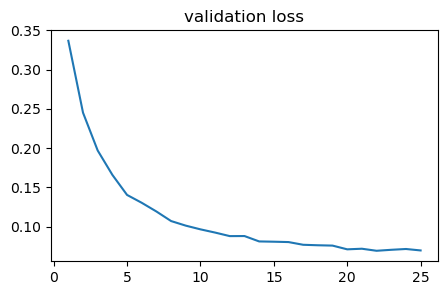

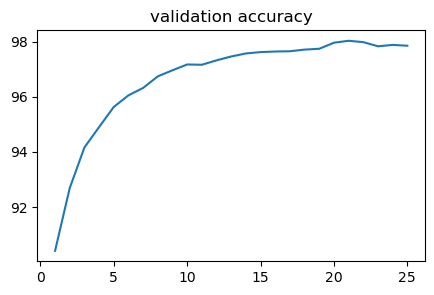

In [25]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128, 10)
        
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
%%time
epochs = 25

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.831429
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.848395
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.896576
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.440564
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.419256
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.463012
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.468770
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.675420
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.295535
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.402244

Validation set: Average loss: 0.3249, Accuracy: 9055/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.298196
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.441267
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.189847
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.248082
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.348518
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.187618
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.604571
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.184303
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.29

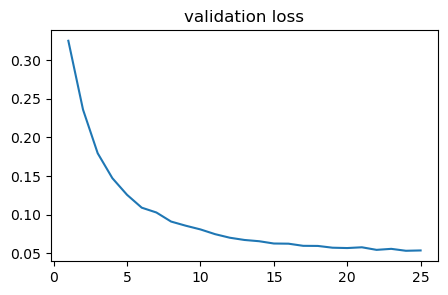

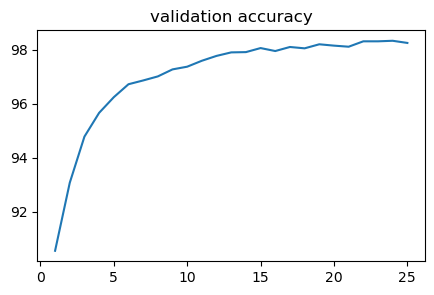

In [28]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128, 64)
        self.fc4_drop = nn.Dropout(0.2)
        self.fc5 = nn.Linear(64, 32)
        self.fc5_drop = nn.Dropout(0.2)
        self.fc6 = nn.Linear(32, 10)
        
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc4_drop): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc5_drop): Dropout(p=0.2, inplace=False)
  (fc6): Linear(in_features=32, out_features=10, bias=True)
)


In [30]:
%%time
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.827247
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.796751
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.798690
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.806340
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.457167
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.469051
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.628985
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.753083
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.433081
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.200714

Validation set: Average loss: 0.3189, Accuracy: 9057/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.362637
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.486490
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.336407
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.295553
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.450026
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.338866
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.309003
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.185958
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.17

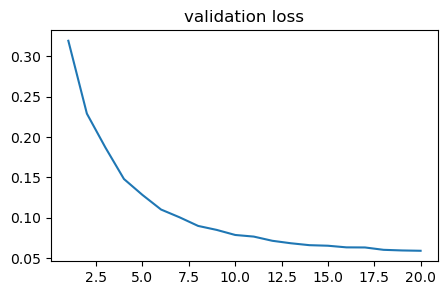

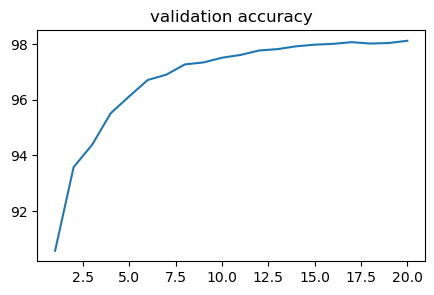

In [31]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');